In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

from dataset import CustomImageDataset
import glob

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

batch_size = 24

train_image_dir = './CIFAR-10-images/train'
train_image_file_list = list(glob.glob(train_image_dir + "/*/*.jpg"))

test_image_dir = './CIFAR-10-images/test'
test_image_file_list = list(glob.glob(train_image_dir + "/*/*.jpg"))

# trainset = CustomImageDataset(train_image_file_list,transform)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# testset = CustomImageDataset(test_image_file_list, transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


tensor(6)


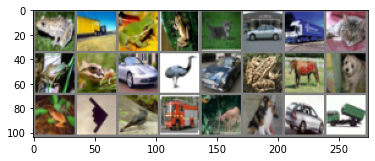

frog  truck frog  frog  cat   car   truck cat   frog  frog  car   bird  car   frog  horse dog   frog  plane bird  truck deer  dog   car   truck


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(labels[0])



# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [15]:
from torchvision.models import resnet18 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net = resnet18(pretrained=False)

for param in net.parameters():
    param.requires_grad = False
    
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)


net.to(torch.device("cuda:0"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.050
[2,  2000] loss: 1.970
[3,  2000] loss: 1.965
[4,  2000] loss: 1.962
[5,  2000] loss: 1.956
[6,  2000] loss: 1.959
[7,  2000] loss: 1.962
[8,  2000] loss: 1.959
[9,  2000] loss: 1.964
[10,  2000] loss: 1.961
[11,  2000] loss: 1.962
[12,  2000] loss: 1.957
[13,  2000] loss: 1.956
[14,  2000] loss: 1.956
[15,  2000] loss: 1.953
[16,  2000] loss: 1.958
[17,  2000] loss: 1.958
[18,  2000] loss: 1.964
[19,  2000] loss: 1.957
[20,  2000] loss: 1.956
[21,  2000] loss: 1.959
[22,  2000] loss: 1.961
[23,  2000] loss: 1.959
[24,  2000] loss: 1.960
[25,  2000] loss: 1.961
Finished Training


In [17]:
PATH = './resnet_cifar.pth'
torch.save(net.state_dict(), PATH)

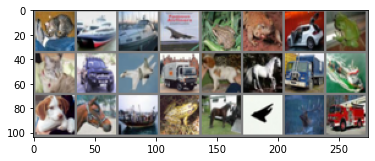

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print(images[0])
#print(labels[0])

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [19]:
net.to('cpu')
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane dog  


In [20]:
correct = 0
total = 0


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 29 %
